![image.png](https://towardsdatascience.com/wp-content/uploads/2024/05/1Qww2aaIdqrWVeNmo3AS0ZQ-2048x1314.png)




## Libraries

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Thermodynamic Length: in terms of model parameters (initial)

In [10]:
MODEL_NAME   = "microsoft/DialoGPT-medium"
MAX_SAMPLES  = 200            # use more for smoother estimates (e.g., 1k+)
BATCH_SIZE   = 2              # increase as memory allows
MAX_SEQ_LEN  = 256            # causal LM, full tokens; keep reasonable for GPU
NUM_WORKERS  = 2
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"


Starting per-layer effort computation (Observed Fisher style, DialoGPT) ...


  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [3]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
SEED = 4242
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# GPU knobs
if DEVICE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")  # PyTorch 2.x
    except Exception:
        pass

In [5]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# GPT-2/DialoGPT has no pad token by default; set pad -> eos for batching
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

# Convenience aliases for GPT-2 style modules
transformer   = model.transformer         # GPT2Model
blocks        = transformer.h             # list of Transformer blocks
final_ln      = transformer.ln_f          # final LayerNorm used before top head
lm_head       = model.lm_head             # tied to embeddings

num_layers = len(blocks)
print(f"Model has {num_layers} decoder blocks")

Loading model: microsoft/DialoGPT-medium


tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

2025-09-12 18:37:45.876680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757702266.207572      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757702266.306658      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model has 24 decoder blocks


##### Datset used: SQuAD
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [6]:
print("Loading SQuAD (train)...")
ds = load_dataset("squad", split="train")

def build_text(example):
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    # Prompt template — simple and consistent:
    return f"Question: {q}\nContext: {c}\nAnswer:"

ds = ds.map(lambda ex: {"text": build_text(ex)}, remove_columns=ds.column_names)

# Filter trivial/very short sequences
ds = ds.filter(lambda ex: len(ex["text"]) > 50)

if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))

print(f"Dataset size after filtering/select: {len(ds)} rows")
print("\nSample prompt:")
print(ds[0]["text"][:400], " ...")

Loading SQuAD (train)...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset size after filtering/select: 200 rows

Sample prompt:
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basil  ...


In [7]:
# Collate: tokenize and build teacher-forced labels (shifted)
def causal_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt",
    )

    input_ids = tok["input_ids"]              # (B, S)
    attention_mask = tok["attention_mask"]    # (B, S)

    # Teacher forcing: predict next token
    # Shift: inputs[:-1], labels[1:]
    input_ids_shifted  = input_ids[:, :-1].contiguous()
    attention_shifted  = attention_mask[:, :-1].contiguous()
    labels_shifted     = input_ids[:, 1:].contiguous()

    # Ignore loss where the target token came from padding in the original sequence
    labels_shifted = labels_shifted.masked_fill(attention_mask[:, 1:] == 0, -100)

    batch = {
        "input_ids": input_ids_shifted,     # tokens up to second-to-last
        "labels": labels_shifted,           # next-token targets (pad -> -100)
        # We won’t use attention_mask in the blocks (causal mask handled internally),
        # but keep it for potential diagnostics:
        "attention_mask": attention_shifted,
    }
    return batch

loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=causal_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [39]:
from transformers.models.qwen2.modeling_qwen2 import Qwen2RotaryEmbedding

rotary_emb = Qwen2RotaryEmbedding(transformer.config)



In [11]:
layer_grad_sums = torch.zeros(num_layers, device=DEVICE)
num_batches = 0
print("\nStarting per-layer effort computation (Observed Fisher style, DialoGPT) ...")
amp_dtype = torch.bfloat16 if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else torch.float16

for batch in tqdm(loader, total=math.ceil(len(ds)/BATCH_SIZE)):
    num_batches += 1
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S)
    B, S = input_ids.shape
    
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        # Token embeddings + positional embeddings (GPT-2 style)
        h = transformer.wte(input_ids)   # Word token embeddings (B, S, d_model)
        pos_ids = torch.arange(S, device=DEVICE).unsqueeze(0).expand(B, S)
        pos_embeds = transformer.wpe(pos_ids)   # Position embeddings
        h = h + pos_embeds   # Add position embeddings
    
    per_layer_losses = []
    for ell in range(num_layers):
        h_prev = h  # keep gradient flow
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            # Forward through transformer block
            out = blocks[ell](h_prev)
            h_ell = out[0]  # GPT-2 blocks return tuple (hidden_states, present)
            
            # Logit lens at this layer
            logits_ell = lm_head(transformer.ln_f(h_ell))  # Apply final layer norm
            loss_ell = F.cross_entropy(
                logits_ell.view(-1, logits_ell.size(-1)),
                labels.view(-1),
                ignore_index=-100,
                reduction="mean",
            )
        per_layer_losses.append(loss_ell)
        h = h_ell
    
    # Backward once for all layers
    model.zero_grad(set_to_none=True)
    total_loss = torch.stack(per_layer_losses).sum()
    total_loss.backward()
    
    # Accumulate squared grad norms
    with torch.no_grad():
        for ell in range(num_layers):
            g2 = torch.tensor(0.0, device=DEVICE)
            for p in blocks[ell].parameters():
                if p.grad is not None:
                    g2 += (p.grad.detach() ** 2).sum()
            layer_grad_sums[ell] += g2

print(f"\nProcessed {num_batches} batches")
print("Per-layer gradient norms (Fisher-style):")
for ell in range(num_layers):
    avg_grad_norm = (layer_grad_sums[ell] / num_batches).sqrt()
    print(f"Layer {ell:2d}: {avg_grad_norm:.6f}")



Starting per-layer effort computation (Observed Fisher style, DialoGPT) ...


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


Processed 100 batches
Per-layer gradient norms (Fisher-style):
Layer  0: 282.314972
Layer  1: 124.007439
Layer  2: 137.147781
Layer  3: 127.337456
Layer  4: 109.429291
Layer  5: 129.798203
Layer  6: 105.784683
Layer  7: 100.221046
Layer  8: 115.147614
Layer  9: 104.511612
Layer 10: 77.137436
Layer 11: 70.990082
Layer 12: 69.431221
Layer 13: 60.687050
Layer 14: 44.808617
Layer 15: 39.608929
Layer 16: 30.146429
Layer 17: 25.846275
Layer 18: 31.352848
Layer 19: 20.194050
Layer 20: 18.342672
Layer 21: 8.567712
Layer 22: 4.892406
Layer 23: 2.280845



--- Per-layer squared gradient norms (mean over batches) ---
Layer  1:  7.970175e+04
Layer  2:  1.537785e+04
Layer  3:  1.880952e+04
Layer  4:  1.621483e+04
Layer  5:  1.197477e+04
Layer  6:  1.684757e+04
Layer  7:  1.119040e+04
Layer  8:  1.004426e+04
Layer  9:  1.325897e+04
Layer 10:  1.092268e+04
Layer 11:  5.950185e+03
Layer 12:  5.039591e+03
Layer 13:  4.820695e+03
Layer 14:  3.682918e+03
Layer 15:  2.007812e+03
Layer 16:  1.568867e+03
Layer 17:  9.088072e+02
Layer 18:  6.680300e+02
Layer 19:  9.830011e+02
Layer 20:  4.077997e+02
Layer 21:  3.364536e+02
Layer 22:  7.340569e+01
Layer 23:  2.393564e+01
Layer 24:  5.202253e+00


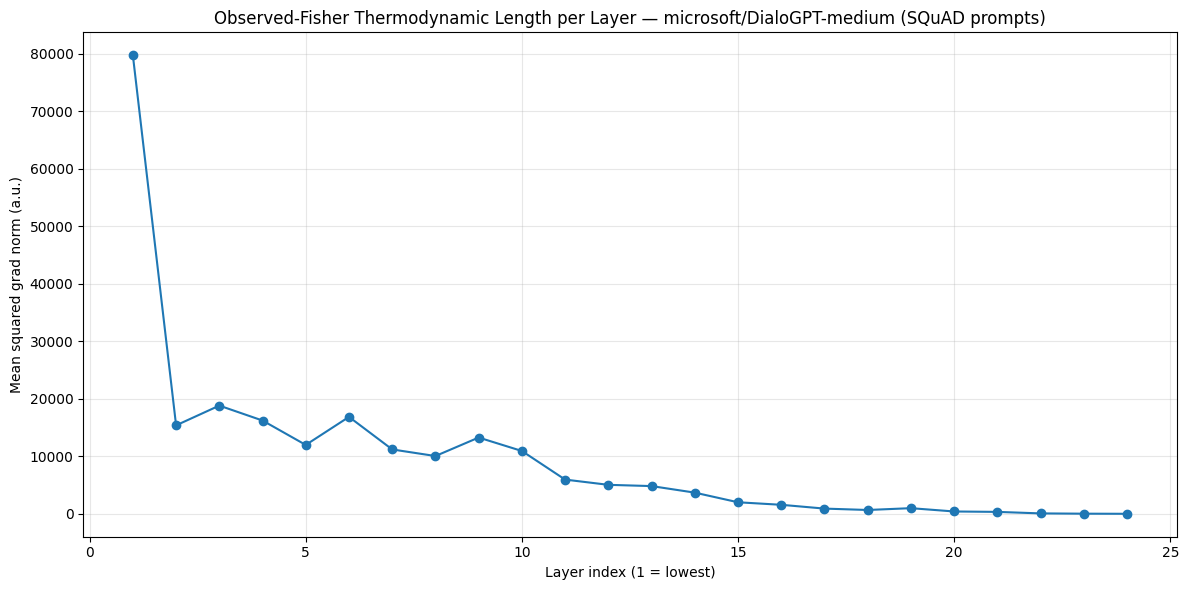

In [12]:
#Results

layer_grad_sums_cpu = layer_grad_sums.detach().cpu().numpy()
mean_layer_grad_sq = layer_grad_sums_cpu / max(1, num_batches)  # mean over batches

print("\n--- Per-layer squared gradient norms (mean over batches) ---")
for i, val in enumerate(mean_layer_grad_sq, start=1):
    print(f"Layer {i:2d}: {val: .6e}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(1, num_layers+1), mean_layer_grad_sq, marker='o')
plt.title(f'Observed-Fisher Thermodynamic Length per Layer — {MODEL_NAME} (SQuAD prompts)')
plt.xlabel('Layer index (1 = lowest)')
plt.ylabel('Mean squared grad norm (a.u.)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Thermodynamic Length: in terms of model predictions (revised) -- The Logit–Simplex Fisher–Rao method


Computing Thermodynamic Length from predictions (Fisher–Rao, exact) ...


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]



--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---
Between layers  1 and  2: 1.114033e+00 rad
Between layers  2 and  3: 9.349279e-01 rad
Between layers  3 and  4: 7.830067e-01 rad
Between layers  4 and  5: 8.869028e-01 rad
Between layers  5 and  6: 8.242082e-01 rad
Between layers  6 and  7: 7.426243e-01 rad
Between layers  7 and  8: 7.661914e-01 rad
Between layers  8 and  9: 1.152593e+00 rad
Between layers  9 and 10: 9.673551e-01 rad
Between layers 10 and 11: 6.738328e-01 rad
Between layers 11 and 12: 6.544784e-01 rad
Between layers 12 and 13: 8.701219e-01 rad
Between layers 13 and 14: 5.251812e-01 rad
Between layers 14 and 15: 6.041710e-01 rad
Between layers 15 and 16: 5.350522e-01 rad
Between layers 16 and 17: 5.178429e-01 rad
Between layers 17 and 18: 4.953289e-01 rad
Between layers 18 and 19: 5.016868e-01 rad
Between layers 19 and 20: 4.994725e-01 rad
Between layers 20 and 21: 4.750937e-01 rad
Between layers 21 and 22: 4.798741e-01 rad
Between layers 2

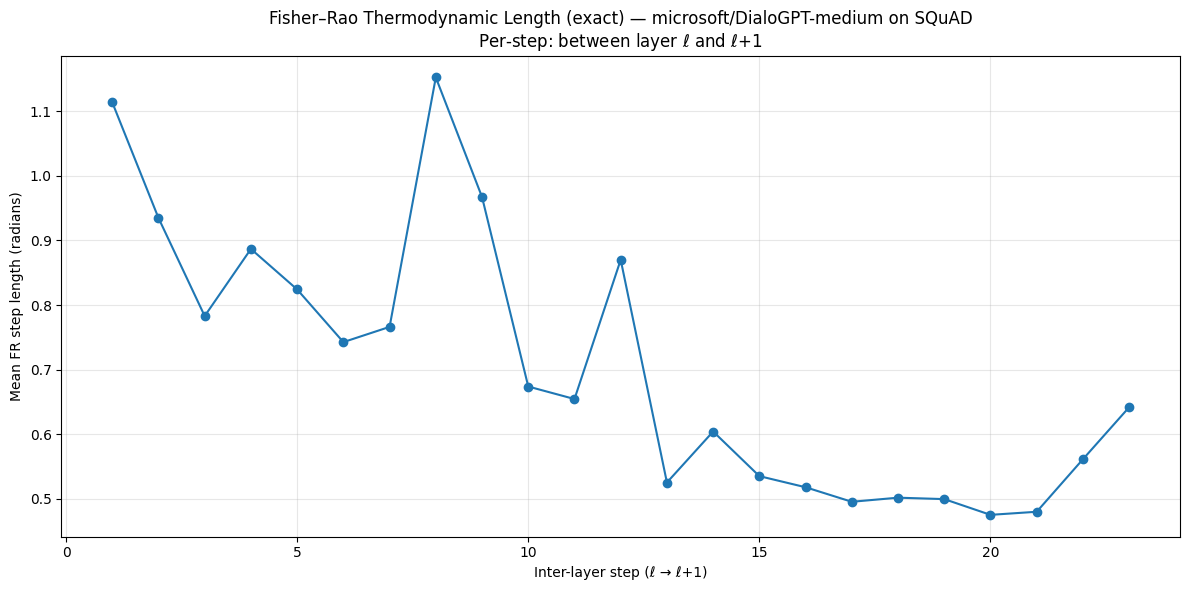

In [13]:
# Accumulators for per-step (between layers) mean FR length
# step k corresponds to "between block k and k+1" → there are (num_layers-1) steps
num_steps = len(blocks) - 1
fr_step_sums   = torch.zeros(num_steps, device=DEVICE)  # sum of FR lengths over valid tokens
fr_step_counts = torch.zeros(num_steps, device=DEVICE)  # count of valid tokens

print("\nComputing Thermodynamic Length from predictions (Fisher–Rao, exact) ...")

@torch.no_grad()
def fr_step_from_logprobs(logp_prev, logp_next, valid_mask):
    """
    logp_prev, logp_next: (B, S, V) log-probabilities for adjacent layers (already log_softmaxed, float32)
    valid_mask:          (B, S) boolean mask for positions with labels != -100

    Returns:
      step_lengths: (B, S) = 2 * arccos( sum_i sqrt(p_prev_i * p_next_i) )
    Numerically stable via log-sum-exp on 0.5*(logp_prev + logp_next).
    """
    # s = 0.5*(logp_prev + logp_next);    BC = sum_i exp(s_i)
    s = 0.5 * (logp_prev + logp_next)                      # (B, S, V)
    log_bc = torch.logsumexp(s, dim=-1)                    # (B, S)
    bc = torch.exp(log_bc)                                 # (B, S), Bhattacharyya coefficient in [0, 1] (numerically may creep outside)
    bc = bc.clamp_(0.0, 1.0)
    steps = 2.0 * torch.acos(bc)                           # (B, S), exact FR step between the two distributions
    if valid_mask is not None:
        steps = steps.masked_fill(~valid_mask, 0.0)
    return steps

# Iterate over SQuAD batches again (teacher-forced)
for batch in tqdm(loader, total=math.ceil(len(loader.dataset)/loader.batch_size)):
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S-1)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S-1)
    B, S = input_ids.shape

    # Build initial hidden state exactly as before
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        h = transformer.wte(input_ids) + transformer.wpe(pos_ids)
        h = transformer.drop(h)

    # We will carry log-probs from the previous layer to compute FR step with the current one
    logp_prev = None

    for ell in range(len(blocks)):
        h = blocks[ell](h)[0]  # forward one block

        # "Logit lens": apply the same final LN + lm_head used at the top
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            logits = lm_head(final_ln(h))                 # (B, S, V)

        # Work in float32 for log-softmax stability
        logp = F.log_softmax(logits.float(), dim=-1)      # (B, S, V), log p^{(ℓ)}

        if logp_prev is not None:
            # Valid positions are exactly where we have a next-token target (labels != -100)
            valid = (labels != -100)                      # (B, S)

            # Exact FR step length between consecutive layers at each position t
            steps = fr_step_from_logprobs(logp_prev, logp, valid)   # (B, S)

            step_idx = ell - 1  # "between block ell-1 and ell"
            fr_step_sums[step_idx]   += steps.sum()
            fr_step_counts[step_idx] += valid.sum()

        logp_prev = logp  # slide window

# Compute mean FR length per inter-layer step
fr_step_means = (fr_step_sums / fr_step_counts.clamp_min(1)).detach().cpu().numpy()

# ----- Report -----
print("\n--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---")
for k, val in enumerate(fr_step_means, start=1):
    print(f"Between layers {k:2d} and {k+1:2d}: {val:.6e} rad")

# Plot profile across depth
plt.figure(figsize=(12, 6))
x = np.arange(1, num_steps+1)
plt.plot(x, fr_step_means, marker='o')
plt.title(f'Fisher–Rao Thermodynamic Length (exact) — {MODEL_NAME} on SQuAD\n'
          f'Per-step: between layer $\\ell$ and $\\ell{{+}}1$')
plt.xlabel('Inter-layer step (ℓ → ℓ+1)')
plt.ylabel('Mean FR step length (radians)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Merge: The Semantic Efficiency

Data successfully aligned. Using parameter strain from layers 1 to 23.
Original Parameter Strain data length: 24
Matched Parameter Strain data length: 23
Belief Change data length: 23

--- Final Metrics ---
Layer |   Param Strain (E_l) |   Belief Change (Δp_l) |  Semantic Efficiency (L_eff)
-------------------------------------------------------------------------------------
    1 |           3.9924e+02 |           1.114033e+00 |                       0.6643
    2 |           1.4689e+02 |           9.349279e-01 |                       1.0861
    3 |           1.0319e+02 |           7.830067e-01 |                       1.0834
    4 |           6.7530e+01 |           8.869028e-01 |                       1.6753
    5 |           5.0453e+01 |           8.242082e-01 |                       1.8532
    6 |           2.8857e+01 |           7.426243e-01 |                       2.3909
    7 |           1.9598e+01 |           7.661914e-01 |                       3.3398
    8 |           1.3507e+0

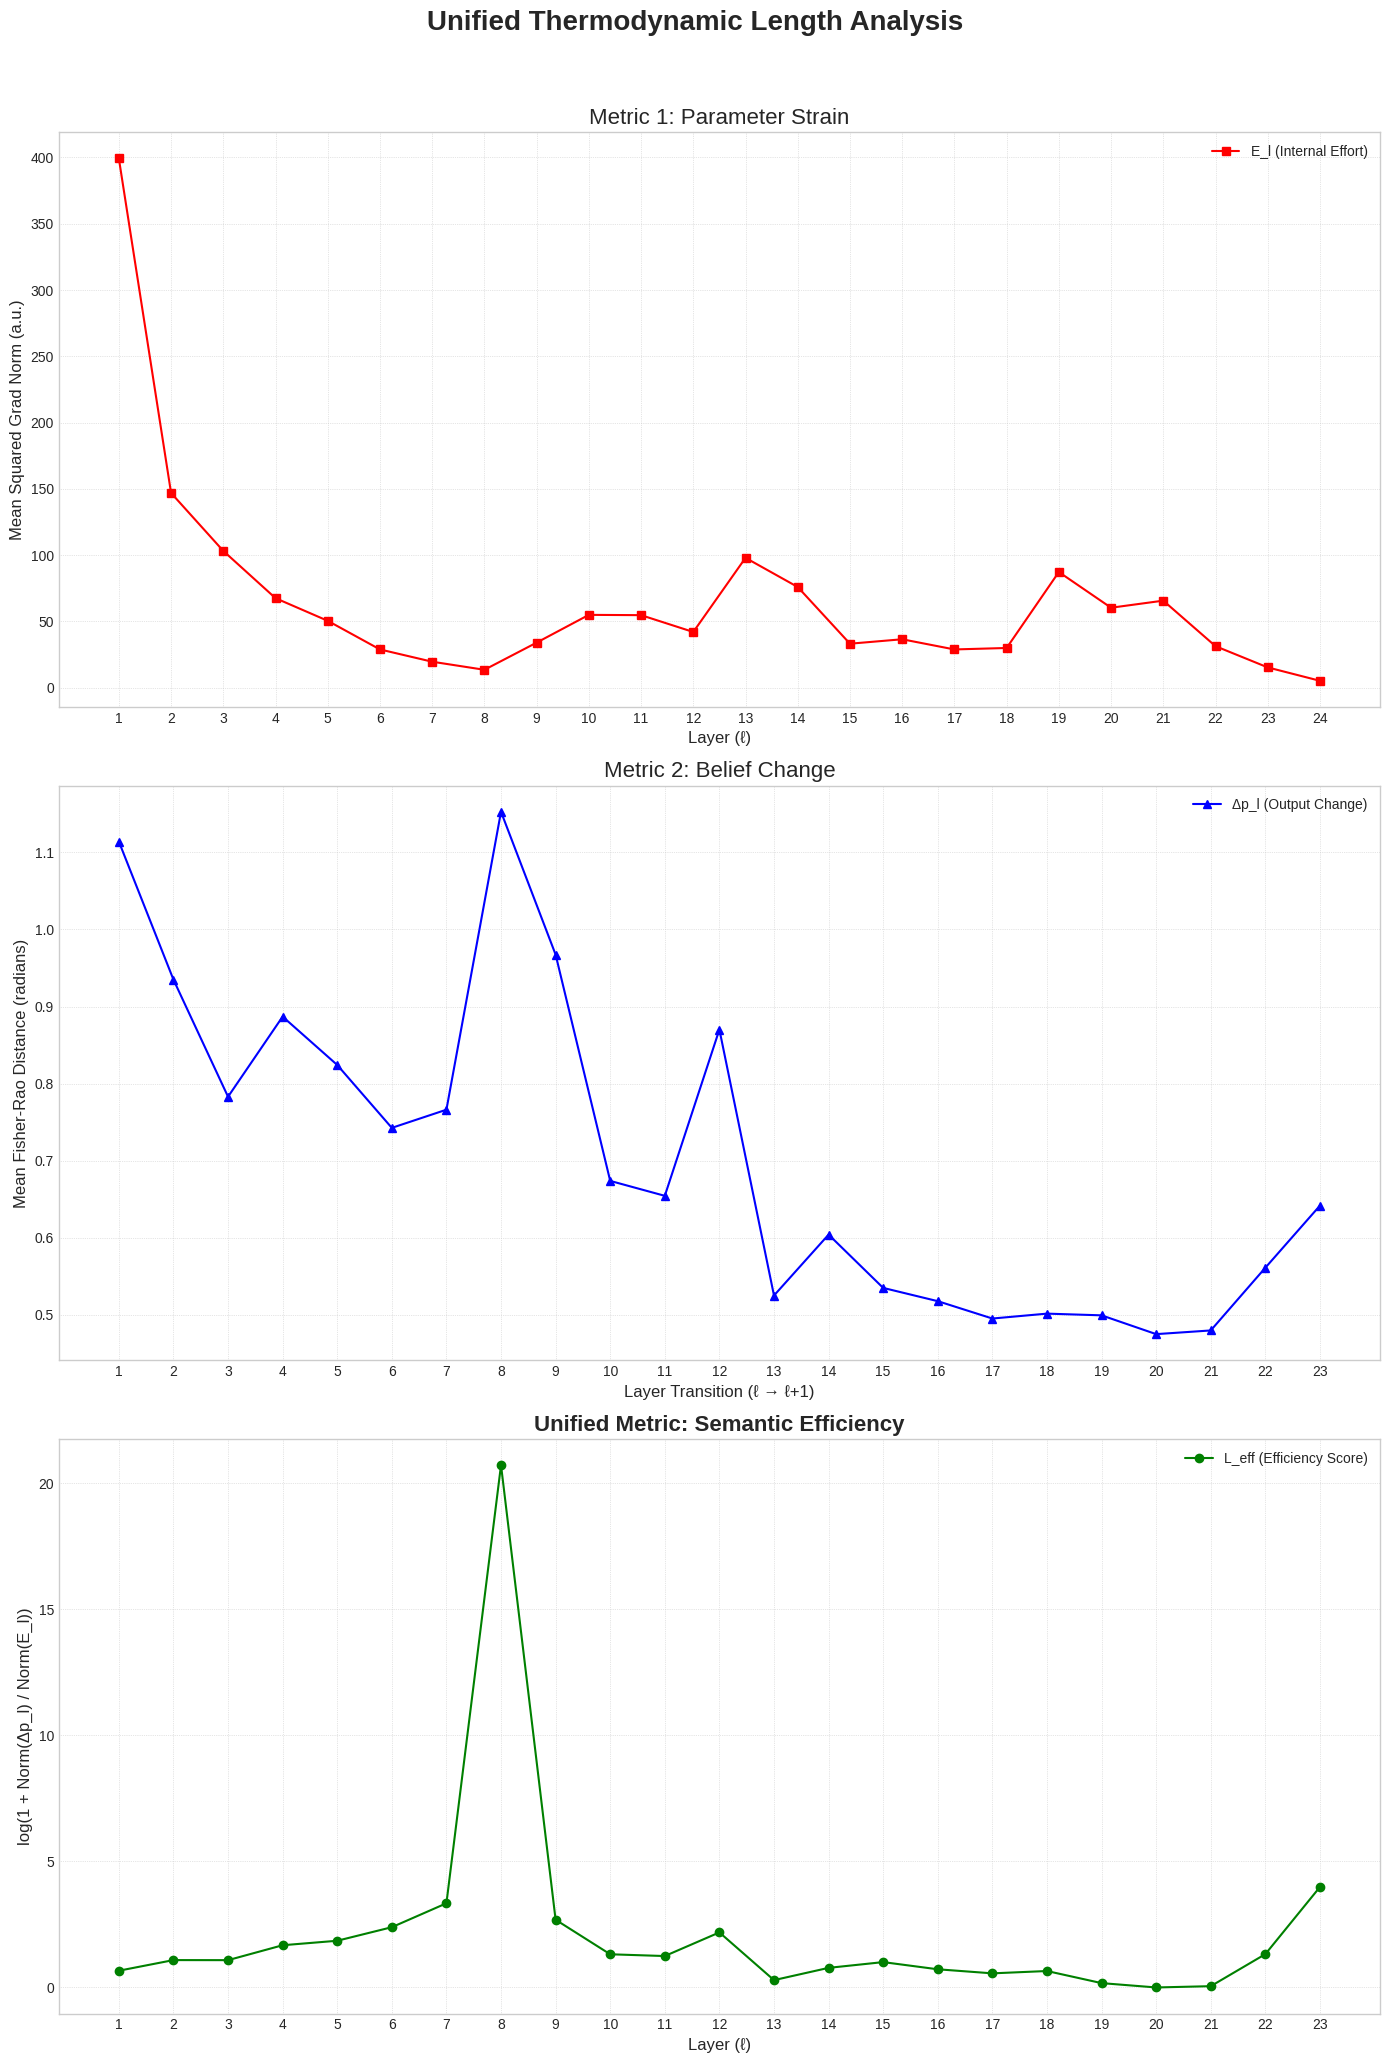

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# Step 1: Input the Raw Data
# ==============================================================================
# As you noted, the first list corresponds to Belief Change (Δp_l)
# and the second to Parameter Strain (E_l).

# Data for Δp_l: Fisher-Rao distance between consecutive layers (23 values)
raw_belief_change = np.array([
    1.114033e+00, 9.349279e-01, 7.830067e-01, 8.869028e-01, 8.242082e-01,
    7.426243e-01, 7.661914e-01, 1.152593e+00, 9.673551e-01, 6.738328e-01,
    6.544784e-01, 8.701219e-01, 5.251812e-01, 6.041710e-01, 5.350522e-01,
    5.178429e-01, 4.953289e-01, 5.016868e-01, 4.994725e-01, 4.750937e-01,
    4.798741e-01, 5.612271e-01, 6.417844e-01
])

# Data for E_l: Mean squared gradient norm at each layer (24 values)
raw_param_strain = np.array([
    3.992427e+02, 1.468945e+02, 1.031877e+02, 6.752973e+01, 5.045254e+01,
    2.885660e+01, 1.959774e+01, 1.350743e+01, 3.399373e+01, 5.494263e+01,
    5.472042e+01, 4.202975e+01, 9.795194e+01, 7.596672e+01, 3.318478e+01,
    3.653396e+01, 2.885680e+01, 2.995477e+01, 8.726003e+01, 6.032204e+01,
    6.566399e+01, 3.132142e+01, 1.530250e+01, 5.202253e+00
])

EPSILON = 1e-9 # Small constant for numerical stability

# ==============================================================================
# Step 2: Handle Mismatched Array Sizes
# ==============================================================================
# The belief change Δp_l happens between layer l and l+1.
# The parameter strain E_l happens AT layer l.
# To calculate the ratio Δp_l / E_l, we pair the change from l->l+1 with the
# strain at layer l. This means we only need the first 23 values of parameter strain.
param_strain_matched = raw_param_strain[:23]

print("Data successfully aligned. Using parameter strain from layers 1 to 23.")
print(f"Original Parameter Strain data length: {len(raw_param_strain)}")
print(f"Matched Parameter Strain data length: {len(param_strain_matched)}")
print(f"Belief Change data length: {len(raw_belief_change)}")


# ==============================================================================
# Step 3: Normalize Both Metrics to a [0, 1] Range
# ==============================================================================
# Normalization is crucial because the raw scales are vastly different.
# This makes their ratio meaningful.
def min_max_scale(x):
    """Scales a numpy array to the [0, 1] range."""
    return (x - x.min()) / (x.max() - x.min() + EPSILON)

norm_param_strain = min_max_scale(param_strain_matched)
norm_belief_change = min_max_scale(raw_belief_change)

# ==============================================================================
# Step 4: Calculate the Final "Semantic Efficiency"
# ==============================================================================
# Formula: L_eff(l) = log(1 + Δp_l_norm / (E_l_norm + ε))
semantic_efficiency = np.log(1 + norm_belief_change / (norm_param_strain + EPSILON))


# ==============================================================================
# Step 5: Report and Plot the Results
# ==============================================================================
print("\n--- Final Metrics ---")
print(f"{'Layer':>5} | {'Param Strain (E_l)':>20} | {'Belief Change (Δp_l)':>22} | {'Semantic Efficiency (L_eff)':>28}")
print("-" * 85)
for i in range(len(semantic_efficiency)):
    print(f"{i+1:>5} | {param_strain_matched[i]:>20.4e} | {raw_belief_change[i]:>22.6e} | {semantic_efficiency[i]:>28.4f}")

# Create a comprehensive 3-panel plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 21), sharex=False)
fig.suptitle('Unified Thermodynamic Length Analysis', fontsize=20, fontweight='bold')

# --- Plot 1: Parameter Strain (E_l) ---
layer_indices_strain = range(1, len(raw_param_strain) + 1)
axes[0].plot(layer_indices_strain, raw_param_strain, marker='s', color='red', label='E_l (Internal Effort)')
axes[0].set_title('Metric 1: Parameter Strain', fontsize=16)
axes[0].set_ylabel('Mean Squared Grad Norm (a.u.)', fontsize=12)
axes[0].set_xlabel('Layer (ℓ)', fontsize=12)
axes[0].set_xticks(layer_indices_strain)
axes[0].legend()
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 2: Belief Change (Δp_l) ---
layer_indices_change = range(1, len(raw_belief_change) + 1)
axes[1].plot(layer_indices_change, raw_belief_change, marker='^', color='blue', label='Δp_l (Output Change)')
axes[1].set_title('Metric 2: Belief Change', fontsize=16)
axes[1].set_ylabel('Mean Fisher-Rao Distance (radians)', fontsize=12)
axes[1].set_xlabel('Layer Transition (ℓ → ℓ+1)', fontsize=12)
axes[1].set_xticks(layer_indices_change)
axes[1].legend()
axes[1].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 3: Semantic Efficiency (L_eff) ---
layer_indices_eff = range(1, len(semantic_efficiency) + 1)
axes[2].plot(layer_indices_eff, semantic_efficiency, marker='o', color='green', label='L_eff (Efficiency Score)')
axes[2].set_title('Unified Metric: Semantic Efficiency', fontsize=16, fontweight='bold')
axes[2].set_ylabel('log(1 + Norm(Δp_l) / Norm(E_l))', fontsize=12)
axes[2].set_xlabel('Layer (ℓ)', fontsize=12)
axes[2].set_xticks(layer_indices_eff)
axes[2].legend()
axes[2].grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

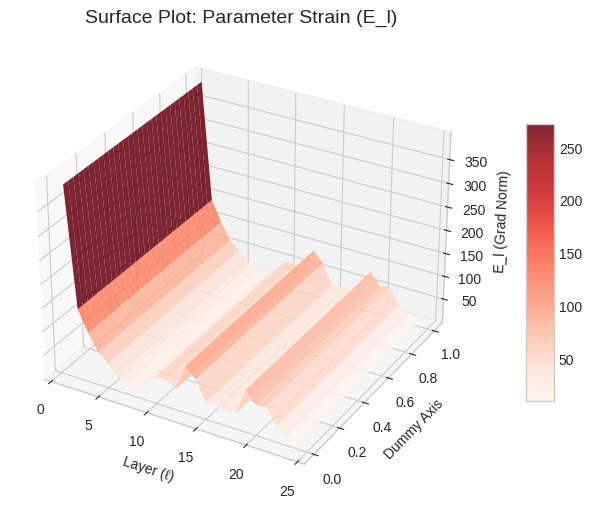

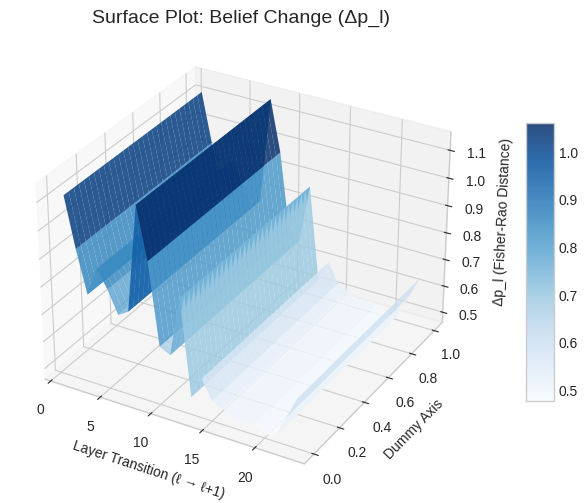

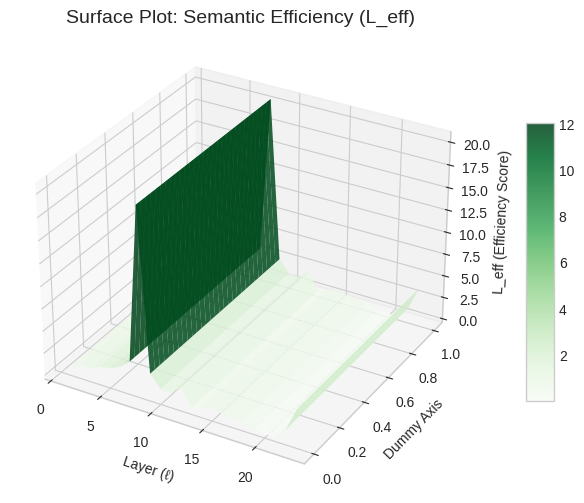

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Create a helper function to turn a 1D sequence into a surface
def make_surface(y, values):
    """
    y: array of indices (like layer numbers)
    values: 1D array of values per index
    Returns meshgrid X, Y, Z suitable for surface plotting
    """
    X, Y = np.meshgrid(y, np.linspace(0, 1, 30))  # add dummy axis
    Z = np.tile(values, (30, 1))  # repeat values along the new axis
    return X, Y, Z


# ==============================================================
# 3D Surface Plot for Parameter Strain
# ==============================================================
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = make_surface(range(1, len(raw_param_strain)+1), raw_param_strain)
surf = ax.plot_surface(X, Y, Z, cmap='Reds', edgecolor='none', alpha=0.85)
ax.set_title("Surface Plot: Parameter Strain (E_l)", fontsize=14)
ax.set_xlabel("Layer (ℓ)")
ax.set_ylabel("Dummy Axis")
ax.set_zlabel("E_l (Grad Norm)")
fig.colorbar(surf, shrink=0.6, aspect=10)
plt.show()


# ==============================================================
# 3D Surface Plot for Belief Change
# ==============================================================
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = make_surface(range(1, len(raw_belief_change)+1), raw_belief_change)
surf = ax.plot_surface(X, Y, Z, cmap='Blues', edgecolor='none', alpha=0.85)
ax.set_title("Surface Plot: Belief Change (Δp_l)", fontsize=14)
ax.set_xlabel("Layer Transition (ℓ → ℓ+1)")
ax.set_ylabel("Dummy Axis")
ax.set_zlabel("Δp_l (Fisher-Rao Distance)")
fig.colorbar(surf, shrink=0.6, aspect=10)
plt.show()


# ==============================================================
# 3D Surface Plot for Semantic Efficiency
# ==============================================================
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = make_surface(range(1, len(semantic_efficiency)+1), semantic_efficiency)
surf = ax.plot_surface(X, Y, Z, cmap='Greens', edgecolor='none', alpha=0.85)
ax.set_title("Surface Plot: Semantic Efficiency (L_eff)", fontsize=14)
ax.set_xlabel("Layer (ℓ)")
ax.set_ylabel("Dummy Axis")
ax.set_zlabel("L_eff (Efficiency Score)")
fig.colorbar(surf, shrink=0.6, aspect=10)
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

# ==============================================================
# Helper: Make Surface from 1D Data
# ==============================================================
def make_surface(y, values):
    X, Y = np.meshgrid(y, np.linspace(0, 1, 30))  # add dummy axis
    Z = np.tile(values, (30, 1))                  # repeat values along new axis
    return X, Y, Z

# ==============================================================
# Helper: Create Rotating GIF
# ==============================================================
def make_rotating_gif(values, title, cmap, zlabel, filename):
    X, Y, Z = make_surface(range(1, len(values)+1), values)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor="none", alpha=0.9)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Layer (ℓ)")
    ax.set_ylabel("Dummy Axis")
    ax.set_zlabel(zlabel)

    def rotate(angle):
        ax.view_init(elev=30, azim=angle)

    ani = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 3), interval=100)
    ani.save(filename, writer=PillowWriter(fps=15))
    plt.close(fig)
    print(f"✅ Saved GIF: {filename}")

# ==============================================================
# Generate All 3 Plots as GIFs
# ==============================================================
make_rotating_gif(
    raw_param_strain,
    title="Surface Plot: Parameter Strain (E_l)",
    cmap="Reds",
    zlabel="E_l (Grad Norm)",
    filename="param_strain.gif"
)

make_rotating_gif(
    raw_belief_change,
    title="Surface Plot: Belief Change (Δp_l)",
    cmap="Blues",
    zlabel="Δp_l (Fisher-Rao Distance)",
    filename="belief_change.gif"
)

make_rotating_gif(
    semantic_efficiency,
    title="Surface Plot: Semantic Efficiency (L_eff)",
    cmap="Greens",
    zlabel="L_eff (Efficiency Score)",
    filename="semantic_efficiency.gif"
)


✅ Saved GIF: param_strain.gif
✅ Saved GIF: belief_change.gif
✅ Saved GIF: semantic_efficiency.gif
